In [31]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import matplotlib.lines as mlines
from scipy.optimize import curve_fit
from scipy.stats import sem
import h5py
from pathlib import Path
from collections.abc import Iterable
from matplotlib.colors import LogNorm

In [32]:
datapath = Path.cwd() / "sector"
datapath2 = Path.cwd().parent / "ED/data/"
figurepath = Path.cwd().parent / "figures/MBL"

In [33]:
W = 5.88    # Figure width in inches, approximately A4-width - 2*1.25in margin
plt.rcParams.update({
    'figure.figsize': (W, W),#/(4/3)),     # 1:1 aspect ratio
    'font.size' : 11,                   # Set font size to 11pt
    'axes.labelsize': 11,               # -> axis labels
    'legend.fontsize': 10,              # -> legends
    'font.family': 'lmodern',
    'text.usetex': True,
    'text.latex.preamble': (            # LaTeX preamble
        r'\usepackage{lmodern}'
        # ... more packages if needed
    )
})

In [34]:
def set_size(width='thesis', fraction=1, subplots=(1, 1),aspect_ratio=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    #aspect_ratio = 1#(5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * aspect_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)


In [35]:
def rearrange_data(arr): #
    res = np.swapaxes(arr,-1,0)
    res = np.swapaxes(res,-2,1)
    return res

def disorder_mean(A, n_samples = None):
    if n_samples is None:
        return np.mean(A,2)
    else:
        return np.mean(A[:,:,0:n_samples],2)

def disorder_std(A, n_samples = None):
    if n_samples is None:
        return np.std(A,2,ddof=1)
    else:
        return np.std(A[:,:,0:n_samples],2,ddof=1)
def disorder_sem(A, n_samples = None):
    if n_samples is None:
        return sem(A,axis=2)
    else:
        return sem(A[:,:,0:n_samples],axis=2)

def symmetrize(arr):
    N = arr.shape[1]
    symarr = np.zeros((arr.shape[0],N//2+1))
    for j in range(0,N//2):
        symarr[:,j] = 0.5*(arr[:,j]+arr[:,N-j-1])
    symarr[:,N//2] = arr[:,N//2]
    return symarr

In [36]:
def idx_transgression(arr,threshold):
    idx = np.zeros(arr.shape[1],dtype=int)
    for j in range(arr.shape[1]):
        found = False
        for i in range(arr.shape[0]):
            if found == False and arr[i,j] >= threshold:
                idx[j] = i
                found = True
        if found == False:
            idx[j] = -1 #be careful that this never breaks things
    return idx

def safeguard_minusone(idx):
    res = np.zeros(idx.shape[0],dtype=float)
    for i in range(idx.shape[0]):
        res[i] = idx[i] if idx[i] != -1 else np.nan
    return res

def mask_transgression(arr,threshold):
    mask = np.zeros(arr.shape,dtype=bool)
    idx = idx_transgression(arr,threshold)
    for j in range(arr.shape[1]):
        if idx[j] != -1:
            mask[idx[j],j]=True
    return mask

def T_transgression(T,arr,threshold):
    idx = idx_transgression(arr,threshold)
    t_past = T[idx]
    t_before = T[[i-1 if i > 0 else 0 for i in idx]]
    arr_past = np.zeros(arr.shape[1])
    arr_before = np.zeros(arr.shape[1])
    t_th = np.zeros(arr.shape[1])
    for j in range(0,arr.shape[1]):
        arr_past[j] = arr[idx[j],j]
        arr_before[j] = arr[idx[j]-1 if idx[j] > 0 else 0,j]

        t_th[j] = (threshold-arr_before[j])/(arr_past[j]-arr_before[j]) * (t_past[j]-t_before[j]) + t_before[j]
    return t_th

In [37]:
jobids = []
params = []
data = []
data_nn = []
folders = [datapath/"k = 7",datapath/"k = 10",datapath2/"zz/h = 24"]
files = ["combined_file_k7.jld2","combined_file_k10.jld2","combined_file_h24.jld2"] 
for (i,file) in enumerate(files):
    with h5py.File(folders[i]/file,"r") as f:
        jobids.append(list(map(lambda s: s.decode("UTF-8"),f["jobid"][()])))
        data.append(2-2*np.array([f[f["data"][l]][()] for l in range(len(f["data"]))]))
        params.append([f[f["params"][l]][()] for l in range(len(f["params"]))])

for  i in range(0,len(files)):
    data[i] = np.concatenate(data[i],axis=0)
    data[i] = rearrange_data(data[i])

In [38]:
N = 13
T = 10 ** np.linspace(-3,6,100)
xcenter = N//2
x = np.arange(0,N//2+1,1)
rvals = np.array([abs(pos-xcenter) for pos in range(0,N)])

In [39]:
res = [disorder_mean(data[i]) for i in range(len(files))]
res_sem = [disorder_sem(data[i]) for i in range(len(files))]
red = list(map(symmetrize,res))
red_sem = list(map(symmetrize,res_sem))

In [40]:
for i in range(len(files)):
    print(data[i].shape[2],"\n")

500 

500 

500 



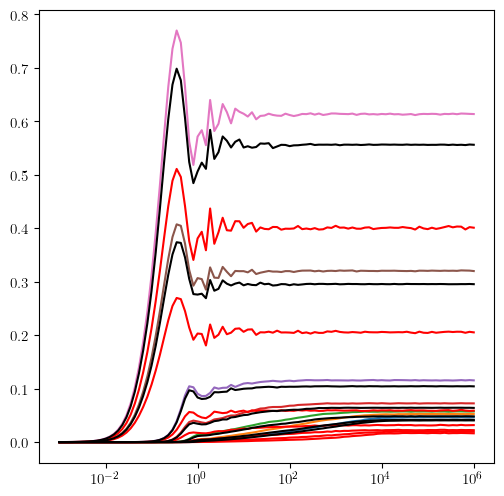

In [43]:
plt.semilogx(T,red[0])
plt.semilogx(T,red[1],c="red")
plt.semilogx(T,red[2],c="black")

In [44]:
ltv = np.zeros((len(red),N//2+1))
ltv_err = np.zeros((len(red),N//2+1))
for i in range(len(red)):
    ltv[i] = np.mean(red[i][77:,:],axis=0)
    ltv_err[i] = np.mean(red_sem[i][77:],axis=0)

In [45]:
ltv

array([[0.04637993, 0.05241266, 0.05718757, 0.07246225, 0.11560731,
        0.32042276, 0.61353453],
       [0.01671507, 0.01946482, 0.02245602, 0.03161619, 0.05913506,
        0.20554231, 0.40094709],
       [0.04039712, 0.04157231, 0.0482626 , 0.06419849, 0.10438514,
        0.29553789, 0.55620557]])

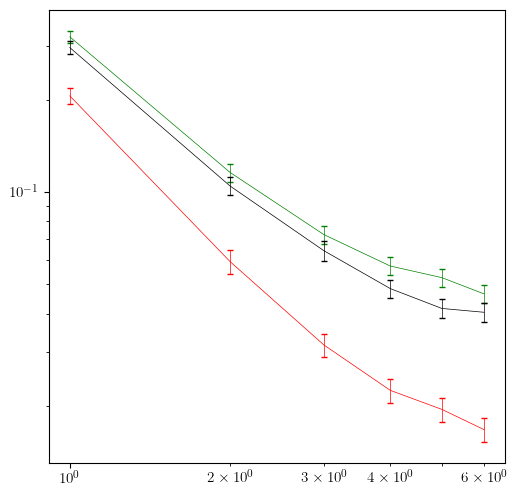

In [47]:
plt.errorbar(rvals[0:N//2],ltv[0,:N//2],yerr=ltv_err[0,:N//2],capsize=2,label="h={}".format(24),c="green",lw=0.5)
plt.errorbar(rvals[0:N//2],ltv[1,:N//2],yerr=ltv_err[1,:N//2],capsize=2,label="h={}".format(24),c="red",lw=0.5)
plt.errorbar(rvals[0:N//2],ltv[2,:N//2],yerr=ltv_err[2,:N//2],capsize=2,label="h={}".format(24),c="black",lw=0.5)
plt.yscale("log")
plt.xscale("log")